# Importing Modules

In [25]:
# LyricsExtract class
import requests
from bs4 import BeautifulSoup
import re
import time
import os

# SpotifyAPI class
import base64
import datetime
import pandas as pd

# WordCounter class
from collections import Counter
import spacy
import advertools as adv
import csv
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

nlp = spacy.load('ja_core_news_sm')

# Classes

### LyricsExtract Class: Downloads Lyrics

In [26]:
class LyricsExtract:
    """Scrapes lyrics from Lyrical Nonsense (https://www.lyrical-nonsense.com/).
    Uses DuckDuckGo to search up the artist and song names.
    Better than UtaNet in that names can be in either English or Japanese.
    However, it is not 100% accurate since it chooses the first result from DuckDuckGo, which is not ideal.
    """
    def __init__(self):
        pass

    def get_beautiful_soup_html(self, url):
        """Returns the HTML of a URL as a BeautifulSoup element."""
        with requests.Session() as session:
            response = session.get(url, headers={'user-agent': 'my-app/0.0.1'})
            html = response.text
        
        soup = BeautifulSoup(html, "html.parser")
        return soup
    
    def get_search_url(self, *args, site="www.lyrical-nonsense.com/lyrics"):
        """Returns a DuckDuckGo URL from the given terms."""
        duckduckgo_base = "https://html.duckduckgo.com/html/?q="
        search_site = "site%3A" + site

        search_terms = ""
        for arg in args:
            arg = "+".join(arg.split())
            search_terms += f"+{arg}"

        search_url = duckduckgo_base + search_site + search_terms
        return search_url
    
    def get_first_duckduckgo_link(self, url):
        """Returns the first link in the DuckDuckGo results page."""
        time.sleep(10)
        soup = self.get_beautiful_soup_html(url)

        try:
            first_link = soup.find("a", class_="result__url").get_text(strip=True)
            first_link = "https://" + first_link
            return first_link
        except AttributeError:
            return False
    
    def get_lyrics(self, url):
        """Extracts lyrics from a Lyrical Nonsense URL."""
        if not url:
            return False

        if not url.startswith("https://www.lyrical-nonsense.com/lyrics"):
            return False
        
        soup = self.get_beautiful_soup_html(url)

        try:
            lyric_sections = soup.find("div", class_="olyrictext").find_all("p")
            lyrics = "\n\n".join([section.get_text() for section in lyric_sections])
            return lyrics
        except:
            return False
    
    def search_for_lyrics(self, artist, track):
        """Returns the lyrics for the given artist and track."""
        search_url = self.get_search_url(artist, track)
        lyrics_url = self.get_first_duckduckgo_link(search_url)
        lyrics = self.get_lyrics(lyrics_url)

        return lyrics
    
    def check_lyrics_file(self, artist, track, folder="output"):
        """Checks if the lyrics file exists on the user's computer."""
        file_name = f"{artist}「{track}」.txt"
        path = os.path.join(folder, file_name)
        return os.path.isfile(path)
    
    def create_lyrics_file(self, artist, track, folder="output"):
        """Creates the lyrics file from the given parameters, if needed."""
        if not self.check_lyrics_file(artist, track, folder):
            lyrics = self.search_for_lyrics(artist, track)

            # case 1: lyrics not found
            if not lyrics:
                print(f"! {artist}「{track}」: Not found")
                return None
            
            # case 2: create lyrics file
            if not os.path.exists(folder):
                os.mkdir(folder)
            
            file_name = f"{artist}「{track}」.txt"
            path = os.path.join(folder, file_name)

            with open(path, "w") as out_file:
                out_file.write(lyrics)
            print(f"* {artist}「{track}」: File created")
        
        # case 3: lyrics file already exists
        else:
            print(f"{artist}「{track}」: File already exists")

### SpotifyAPI Class: Accesses the Spotify API

Most of the code for the SpotifyAPI class below was adapted from the YouTube channel CodingEntrepreneurs.
- [30 Days of Python - Day 19 - The Spotify API - Python TUTORIAL](https://youtu.be/xdq6Gz33khQ)
- [Code in the Video (Github)](https://github.com/codingforentrepreneurs/30-Days-of-Python/tree/master/tutorial-reference/Day%2019/notebooks)

In [27]:
class SpotifyAPI:
    """Accesses the Spotify API to retrieve playlist information.
    Uses the LyricsExtract class above to download lyrics.
    """
    ### Authorization

    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    token_url = "https://accounts.spotify.com/api/token"

    def __init__(self, client_id=None, client_secret=None):
        """Initializes the class, taking in the user's client credentials."""
        self.client_id = client_id
        self.client_secret = client_secret
    
    def get_client_credentials(self):
        """Returns a base64 encoded string."""
        client_id = self.client_id
        client_secret = self.client_secret

        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")

        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()

    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        }
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()

        r = requests.post(token_url, data=token_data, headers=token_headers)
        valid_request = r.status_code in range(200, 299)

        if not valid_request:
            raise Exception("Could not authenticate client")
        
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        
        return True # authenticated fine

    def get_access_token(self):  
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()

        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        
        elif token == None:
            self.perform_auth()
            return self.get_access_token()

        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}",
            "scope": "playlist-read-private",
            "Accept-Language": "ja;q=1"
        }
        return headers
    
    ### Playlist and Lyrics 

    def get_playlist_info(self, _id):
        endpoint = f"https://api.spotify.com/v1/playlists/{_id}"
        headers = self.get_resource_header()

        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        
        return r.json()
    
    def get_tracks_and_artists(self, _id):
        playlist = self.get_playlist_info(_id)

        tracks = [track["track"]["name"] for track in playlist["tracks"]["items"]]
        artists = [track["track"]["artists"][0]["name"] for track in playlist["tracks"]["items"]]

        return tracks, artists
    
    def create_tracks_df(self, _id):
        tracks, artists = self.get_tracks_and_artists(_id)
        data = {"Artist": artists, "Track": tracks}
        df = pd.DataFrame(data)
        sorted_df = df.sort_values(by=["Artist", "Track"]).reset_index(drop=True)
        return sorted_df
    
    def get_lyrics_for_all_songs(self, _id, folder="output"):
        df = self.create_tracks_df(_id)
        for track, artist in zip(df["Track"], df["Artist"]):
            artist = artist.replace("/", " ")
            LyricsExtract().create_lyrics_file(artist, track, folder)
        print("Finished.")

### WordCounter Class: Counts Word Frequencies in Lyrics

In [28]:
class WordCounter:
    """Counts words in a folder and visualizes their frequencies with a horizontal bar chart."""
    def __init__(self):
        """Initializes the class."""
        self.counter = Counter()
    
    def get_stopwords(self):
        """Returns a list of stopwords (words to skip when going through a file)."""
        ja_stopwords = adv.stopwords['japanese']
        other_chars = ['\n', '。', '\n\n', '、', '\u3000', '？', '「', '」', '.', ',', '－', \
            '（', '）', '(', ')', '＇', '－', '’', '!', '！', '『', '』']
        ja_stopwords.update(other_chars)
        return ja_stopwords

    def get_lemmas(self, file):
        """Get all of the lemmas (standardized forms) of a file."""
        with open(file) as f:
            text = f.read()
            doc = nlp(text)
        
        stopwords = self.get_stopwords()
        lemmas = [token.lemma_ for token in doc if str(token) not in stopwords]
        
        return lemmas
    
    def count_words(self, file):
        """Count all words in a .txt file."""
        lemmas = self.get_lemmas(file)
        self.counter.update(lemmas)
        return self.counter.most_common()

    def count_all_words(self, folder="output"):
        """Count all words of all .txt files in a folder."""
        files = os.listdir(folder)
        
        for file in files:
            filepath = os.path.join(folder, file)
            self.count_words(filepath)
        
        return self.counter.most_common()
    
    def output_word_freqs(self, folder, file_name, type="csv", directory="results"):
        """Outputs the word frequencies in a folder of .txt file as either a .csv 
        or .txt file.
        """
        word_freqs = self.count_all_words(folder)

        if not os.path.exists(directory):
            os.mkdir(directory)

        if type == "csv":
            with open(f"{directory}/{file_name}.csv", "w") as f:
                writer = csv.writer(f)
                writer.writerow(["Word", "Frequency"])

                for word, freq in word_freqs:
                    writer.writerow([word, freq])

        else:
            with open(f"{directory}/{file_name}.txt", "w") as f:
                for word, freq in word_freqs:
                    f.write(f"{word} - {freq}\n")
    
    def visualize_word_freqs(self, folder_name, file_name, n=30, directory="results"):
        """Shows a plot with the n most common words in a folder of .txt files."""
        self.output_word_freqs(folder_name, file_name)
        df = pd.read_csv(f"{directory}/{file_name}.csv")

        words = df["Word"][:n][::-1]
        freqs = df["Frequency"][:n][::-1]

        plt.rc('axes', titlesize=25)
        plt.figure(figsize=(10, 7.5))
        plt.xlabel("Frequencies")
        plt.ylabel("Words")
        plt.title(f"Top {n} words in the folder '{folder_name}'")
        plt.rc('xtick', labelsize=10)
        plt.rc('ytick', labelsize=10)
        plt.rc('axes', labelsize=15)

        plt.barh(words, freqs)
        plt.show()

# Tests

In [29]:
client_id = "your_client_id"
client_secret = "your_client_secret"
spotify = SpotifyAPI(client_id, client_secret)

In [32]:
spotify.create_tracks_df("37i9dQZF1EIYEv8LTId1b8")

,Artist,Track
0,MAISONdes,Cheers
1,MAISONdes,Grumpy
2,MAISONdes,ダンス・ダンス・ダダ
3,MAISONdes,ヨワネハキ
4,MAISONdes,ラリー、ラリー
5,Mrs. GREEN APPLE,JOURNEY
6,Mrs. GREEN APPLE,lovin'
7,Mrs. GREEN APPLE,インフェルノ
8,Mrs. GREEN APPLE,ダンスホール
9,Mrs. GREEN APPLE,ロマンチシズム


In [31]:
spotify.get_lyrics_for_all_songs("37i9dQZF1EIYEv8LTId1b8", "test")

MAISONdes「Cheers」: File already exists
MAISONdes「Grumpy」: File already exists
MAISONdes「ダンス・ダンス・ダダ」: File already exists
! MAISONdes「ヨワネハキ」: Not found
! MAISONdes「ラリー、ラリー」: Not found
Mrs. GREEN APPLE「JOURNEY」: File already exists
Mrs. GREEN APPLE「lovin'」: File already exists
Mrs. GREEN APPLE「インフェルノ」: File already exists
* Mrs. GREEN APPLE「ダンスホール」: File created
* Mrs. GREEN APPLE「ロマンチシズム」: File created
* yama「MoonWalker」: File created
yama「Oz.」: File already exists
! yama「春を告げる」: Not found
yama「桃源郷」: File already exists
くじら「Sleeping town」: File already exists
ヨルシカ「あの夏に咲け」: File already exists
ヨルシカ「ただ君に晴れ」: File already exists
ヨルシカ「だから僕は音楽を辞めた」: File already exists
ヨルシカ「エルマ」: File already exists
ヨルシカ「ヒッチコック」: File already exists
ヨルシカ「ブレーメン」: File already exists
* ヨルシカ「レプリカント」: File created
ヨルシカ「五月は花緑青の窓辺から」: File already exists
ヨルシカ「冬眠」: File already exists
ヨルシカ「嘘月」: File already exists
* ヨルシカ「左右盲」: File created
* ヨルシカ「心に穴が空いた」: File created
* ヨルシカ「思想犯」: File created
* ヨルシカ「春泥棒」: File cr

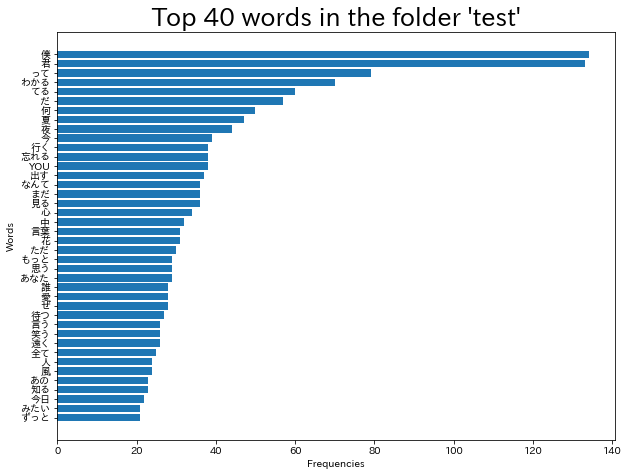

In [33]:
WordCounter().visualize_word_freqs("test", "yorushika-mix", 40)